In [ ]:
#載入所需函式庫
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#載入資料
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/house/'

train_data = pd.read_csv(data_path + 'train-v3.csv')
valid_data = pd.read_csv(data_path + 'valid-v3.csv')
test_data = pd.read_csv(data_path + 'test-v3.csv')

print(train_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           id   price  sale_yr  sale_month  sale_day  bedrooms  bathrooms  \
0  5615100330  200000     2015           3        27         4        2.0   
1  8835900086  350000     2014           9         2         4        3.0   
2  9510900270  254000     2014          12        11         3        2.0   
3  2621600015  175000     2015           4        30         3        1.0   
4  8078350090  619000     2015           3        31         3        2.5   

   sqft_living  sqft_lot  floors  ...  grade  sqft_above  sqft_basement  \
0         1900      8160       1  ...      7        1900              0   
1         3380     16133       1  ...      8        2330           1050   
2         2070      9000       1  ...      7        1450            620   
3         1150      8924       1  ...      6        1150              0   
4         2040      7503       2 

In [ ]:
#資料預處理
train_data = train_data.drop(columns=['id'])
valid_data = valid_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])


scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop(columns=['price']))
y_train = train_data['price']
X_valid = scaler.transform(valid_data.drop(columns=['price']))
y_valid = valid_data['price']
X_test = scaler.transform(test_data)

In [ ]:
#模型設計與訓練
model = xgb.XGBRegressor(
    n_estimators=1850,
    learning_rate=0.02,
    max_depth=6,
    colsample_bytree=0.75,
    subsample=0.75,
    reg_alpha=0.1, reg_lambda=0.1,
    objective='reg:squarederror')

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric=['rmse'], early_stopping_rounds=80, verbose=False)


results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)



for epoch in range(epochs):
    train_rmse = results['validation_0']['rmse'][epoch]
    valid_rmse = results['validation_1']['rmse'][epoch]
    print(f'Epoch [{epoch+1}/{epochs}], Train RMSE: {train_rmse:.4f}, Valid RMSE: {valid_rmse:.4f}')


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Epoch [1/1850], Train RMSE: 638726.6942, Valid RMSE: 618837.7634
Epoch [2/1850], Train RMSE: 626823.0316, Valid RMSE: 607392.2386
Epoch [3/1850], Train RMSE: 615400.4177, Valid RMSE: 596405.2521
Epoch [4/1850], Train RMSE: 604083.5439, Valid RMSE: 585348.2297
Epoch [5/1850], Train RMSE: 592959.5034, Valid RMSE: 574670.9477
Epoch [6/1850], Train RMSE: 582226.8109, Valid RMSE: 564426.1093
Epoch [7/1850], Train RMSE: 571964.7545, Valid RMSE: 554065.9913
Epoch [8/1850], Train RMSE: 561647.0536, Valid RMSE: 544048.5877
Epoch [9/1850], Train RMSE: 551395.0272, Valid RMSE: 534094.3443
Epoch [10/1850], Train RMSE: 541553.6653, Valid RMSE: 524078.0448
Epoch [11/1850], Train RMSE: 531909.5105, Valid RMSE: 514730.5599
Epoch [12/1850], Train RMSE: 522412.2422, Valid RMSE: 505468.6532
Epoch [13/1850], Train RMSE: 512976.2413, Valid RMSE: 496183.8014
Epoch [14/1850], Train RMSE: 503749.6279, Valid RMSE: 486848.6971
Epoch [15/1850], Train RMSE: 494811.3046, Valid RMSE: 478341.4678
Epoch [16/1850], Tr

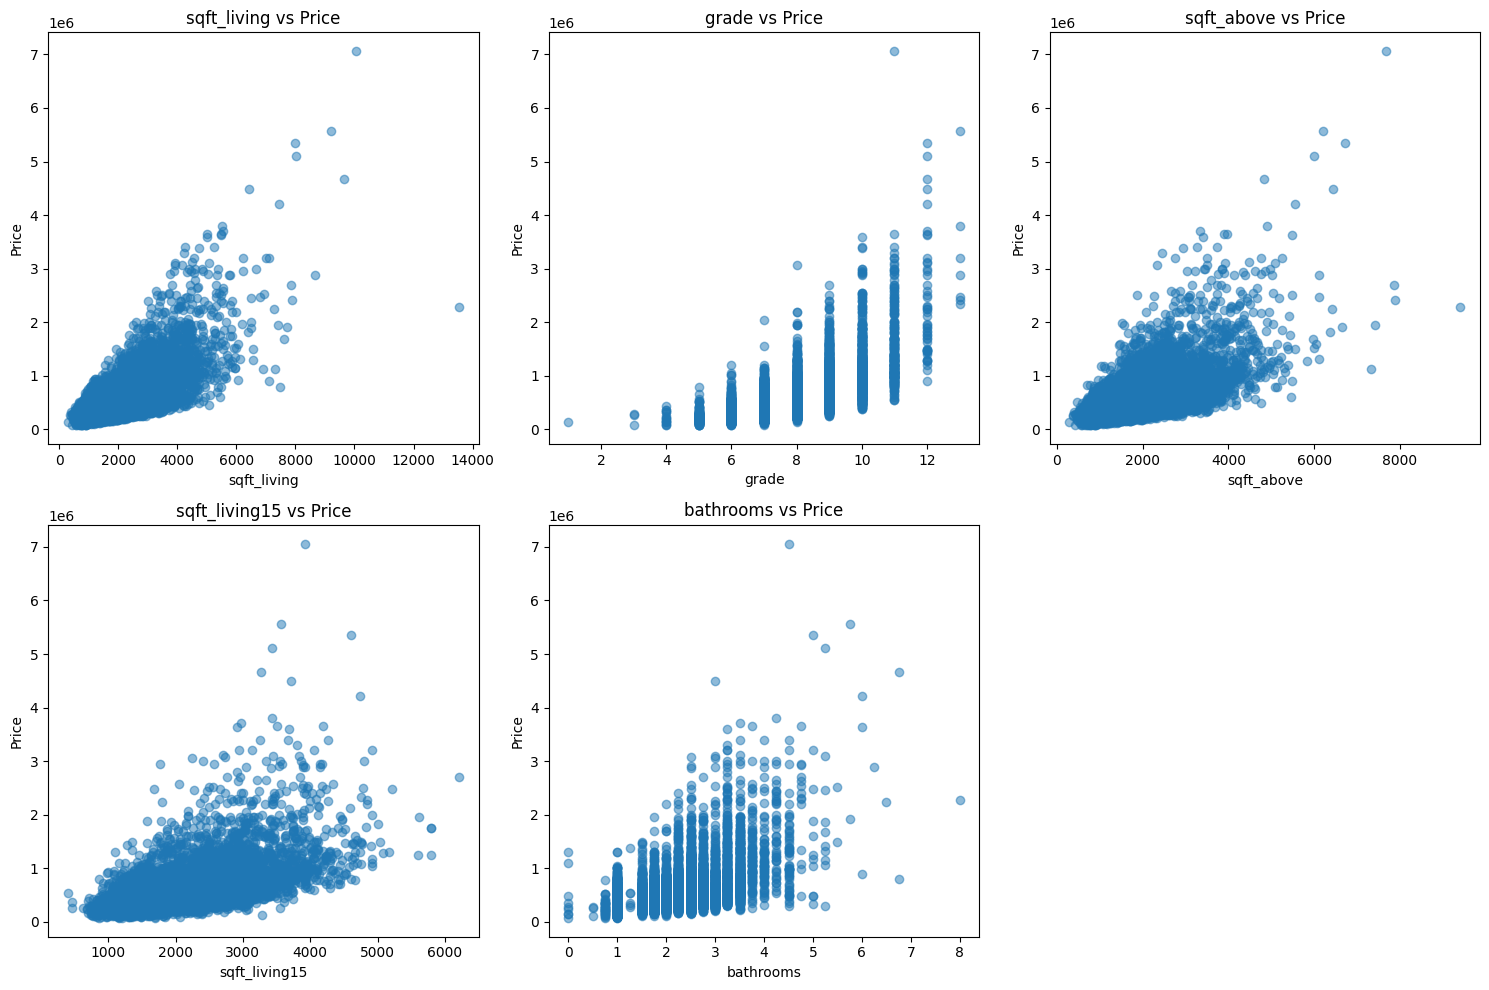

In [ ]:
#繪製房價與參數關係圖
corr_matrix = train_data.corr()
top_features = corr_matrix['price'].abs().sort_values(ascending=False)[1:6].index

plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    plt.scatter(train_data[feature], train_data['price'], alpha=0.5)
    plt.title(f'{feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


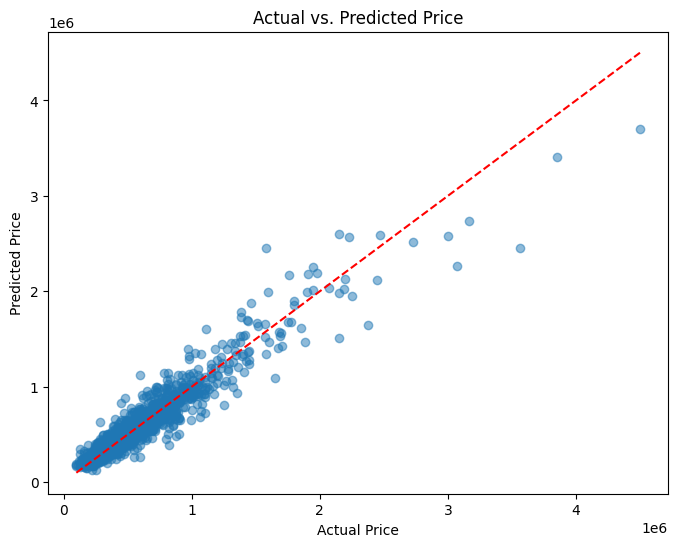

In [ ]:
#繪製預測與真實價格散點圖
predictions = model.predict(X_valid)

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, predictions, alpha=0.5)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.show()


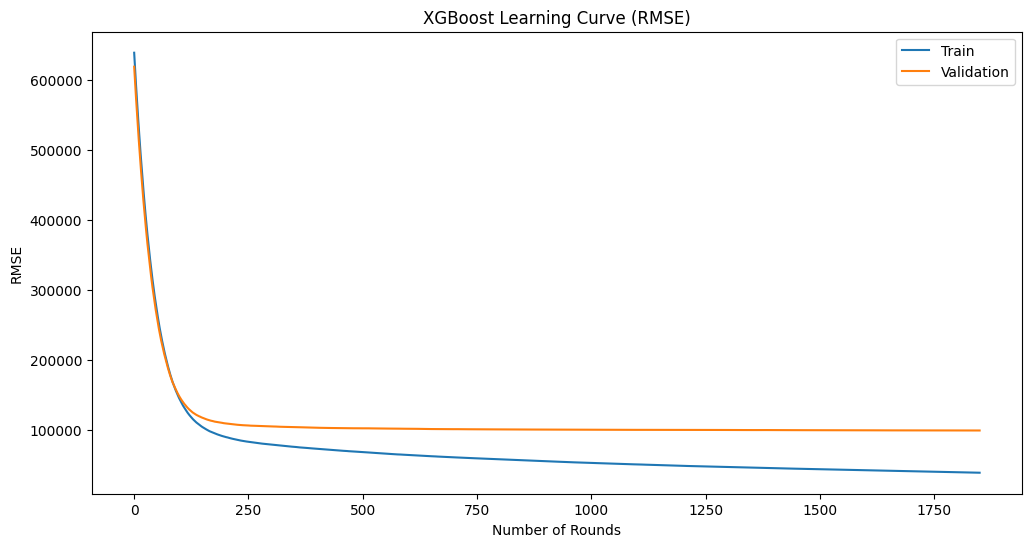

In [ ]:
#繪製loss function
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.title('XGBoost Learning Curve (RMSE)')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [ ]:
#顯示最後loss function訓練結果
final_rmse = results['validation_1']['rmse'][-1]
print(f'Final Validation RMSE: {final_rmse:.2f}')

mae = mean_absolute_error(y_valid, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

test_predictions = model.predict(X_test)

Final Validation RMSE: 99631.60
Mean Absolute Error (MAE): 59245.93


In [ ]:
#存檔印出
submission_df = pd.DataFrame({'id': np.arange(1, len(test_predictions)+1), 'price': test_predictions})
submission_df.to_csv(data_path + 'XGBOOSTprediction.csv', index=False)